# **Processing Sequences using RNNs and CNNs**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def generate_time_series(batch_size, n_steps):
    """Generate synthetic time series data"""
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)    # + noise
    return series[..., np.newaxis].astype(np.float32)

# Generate data
n_steps = 50
print("Generating time series data...")
series = generate_time_series(10000, n_steps + 10)

# Split data for single-step prediction
X_train_single, y_train_single = series[:7000, :n_steps], series[:7000, n_steps, 0]
X_valid_single, y_valid_single = series[7000:9000, :n_steps], series[7000:9000, n_steps, 0]
X_test_single, y_test_single = series[9000:, :n_steps], series[9000:, n_steps, 0]

# Split data for multi-step prediction
X_train_multi, Y_train_multi = series[:7000, :n_steps], series[:7000, n_steps:, 0]
X_valid_multi, Y_valid_multi = series[7000:9000, :n_steps], series[7000:9000, n_steps:, 0]
X_test_multi, Y_test_multi = series[9000:, :n_steps], series[9000:, n_steps:, 0]

print(f"Training data shape: {X_train_single.shape}")
print(f"Single-step target shape: {y_train_single.shape}")
print(f"Multi-step target shape: {Y_train_multi.shape}")

# Custom metric for multi-step prediction
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

Generating time series data...
Training data shape: (7000, 50, 1)
Single-step target shape: (7000,)
Multi-step target shape: (7000, 10)


## Linear

In [2]:
# 1. Simple Linear Model
print("\n=== 1. Simple Linear Model ===")
model_linear = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(1)
])
model_linear.compile(loss="mse", optimizer="adam")
history_linear = model_linear.fit(X_train_single, y_train_single, epochs=20,
                                 validation_data=(X_valid_single, y_valid_single),
                                 verbose=0)
linear_loss = model_linear.evaluate(X_test_single, y_test_single, verbose=0)
print(f"Linear Model Test MSE: {linear_loss:.4f}")


=== 1. Simple Linear Model ===
Linear Model Test MSE: 0.0041


## Simple RNN

In [3]:
# 2. Simple RNN
print("\n=== 2. Simple RNN ===")
model_simple_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])
model_simple_rnn.compile(loss="mse", optimizer="adam")
history_simple_rnn = model_simple_rnn.fit(X_train_single, y_train_single, epochs=20,
                                         validation_data=(X_valid_single, y_valid_single),
                                         verbose=0)
simple_rnn_loss = model_simple_rnn.evaluate(X_test_single, y_test_single, verbose=0)
print(f"Simple RNN Test MSE: {simple_rnn_loss:.4f}")


=== 2. Simple RNN ===
Simple RNN Test MSE: 0.0029


## Deep RNN

In [4]:
# 3. Deep RNN
print("\n=== 3. Deep RNN ===")
model_deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model_deep_rnn.compile(loss="mse", optimizer="adam")
history_deep_rnn = model_deep_rnn.fit(X_train_single, y_train_single, epochs=20,
                                     validation_data=(X_valid_single, y_valid_single),
                                     verbose=0)
deep_rnn_loss = model_deep_rnn.evaluate(X_test_single, y_test_single, verbose=0)
print(f"Deep RNN Test MSE: {deep_rnn_loss:.4f}")



=== 3. Deep RNN ===
Deep RNN Test MSE: 0.0024


## LSTM

In [5]:
# 4. LSTM Model
print("\n=== 4. LSTM Model ===")
model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])
model_lstm.compile(loss="mse", optimizer="adam")
history_lstm = model_lstm.fit(X_train_single, y_train_single, epochs=20,
                             validation_data=(X_valid_single, y_valid_single),
                             verbose=0)
lstm_loss = model_lstm.evaluate(X_test_single, y_test_single, verbose=0)
print(f"LSTM Test MSE: {lstm_loss:.4f}")


=== 4. LSTM Model ===
LSTM Test MSE: 0.0022


## GRU

In [6]:
# 5. GRU Model
print("\n=== 5. GRU Model ===")
model_gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(1)
])
model_gru.compile(loss="mse", optimizer="adam")
history_gru = model_gru.fit(X_train_single, y_train_single, epochs=20,
                           validation_data=(X_valid_single, y_valid_single),
                           verbose=0)
gru_loss = model_gru.evaluate(X_test_single, y_test_single, verbose=0)
print(f"GRU Test MSE: {gru_loss:.4f}")


=== 5. GRU Model ===
GRU Test MSE: 0.0030


## CNN-RNN Hybrid

In [8]:
# 7. CNN-RNN Hybrid Model
print("\n=== 7. CNN-RNN Hybrid ===")
model_cnn_rnn = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                       input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20),
    keras.layers.Dense(1)
])
model_cnn_rnn.compile(loss="mse", optimizer="adam")
history_cnn_rnn = model_cnn_rnn.fit(X_train_single, y_train_single, epochs=20,
                                   validation_data=(X_valid_single, y_valid_single),
                                   verbose=0)
cnn_rnn_loss = model_cnn_rnn.evaluate(X_test_single, y_test_single, verbose=0)
print(f"CNN-RNN Hybrid Test MSE: {cnn_rnn_loss:.4f}")


=== 7. CNN-RNN Hybrid ===
CNN-RNN Hybrid Test MSE: 0.0028


## WaveNet

In [9]:
# 8. WaveNet-style Model (Dilated Convolutions)
print("\n=== 8. WaveNet-style Model ===")
model_wavenet = keras.models.Sequential()
model_wavenet.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model_wavenet.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                         activation="relu", dilation_rate=rate))
model_wavenet.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model_wavenet.add(keras.layers.GlobalMaxPooling1D())  # Added to get single output

model_wavenet.compile(loss="mse", optimizer="adam")
history_wavenet = model_wavenet.fit(X_train_single, y_train_single, epochs=20,
                                   validation_data=(X_valid_single, y_valid_single),
                                   verbose=0)
wavenet_loss = model_wavenet.evaluate(X_test_single, y_test_single, verbose=0)
print(f"WaveNet-style Test MSE: {wavenet_loss:.4f}")



=== 8. WaveNet-style Model ===
WaveNet-style Test MSE: 0.1407



=== Model Comparison ===
Model Performance (Test MSE):
LSTM        : 0.0022
Deep RNN    : 0.0024
CNN-RNN     : 0.0028
Simple RNN  : 0.0029
GRU         : 0.0030
Linear      : 0.0041
WaveNet     : 0.1407


ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

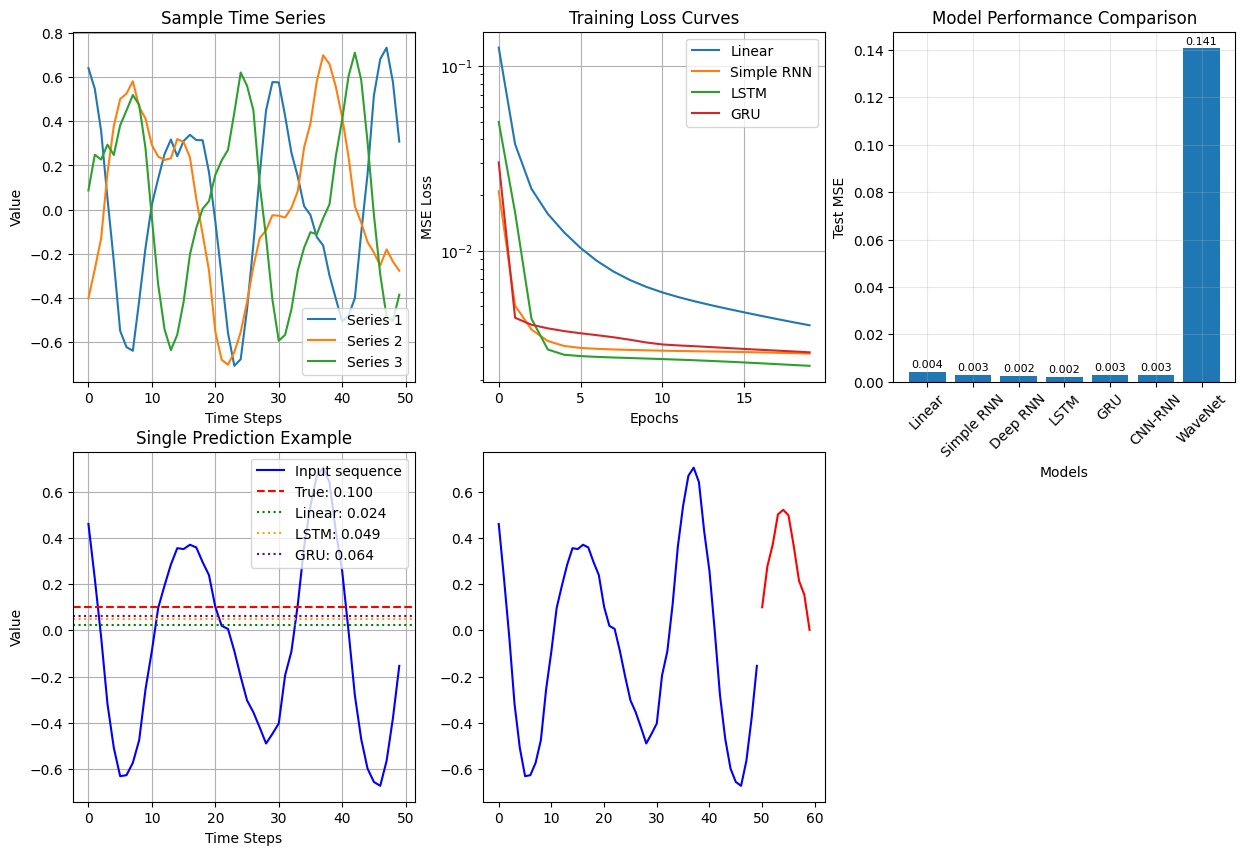

In [10]:
# Compare all models
print("\n=== Model Comparison ===")
results = {
    'Linear': linear_loss,
    'Simple RNN': simple_rnn_loss,
    'Deep RNN': deep_rnn_loss,
    'LSTM': lstm_loss,
    'GRU': gru_loss,
    'CNN-RNN': cnn_rnn_loss,
    'WaveNet': wavenet_loss
}

print("Model Performance (Test MSE):")
for model_name, mse in sorted(results.items(), key=lambda x: x[1]):
    print(f"{model_name:12}: {mse:.4f}")

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Sample time series
plt.subplot(2, 3, 1)
sample_series = generate_time_series(3, n_steps)
for i in range(3):
    plt.plot(sample_series[i, :, 0], label=f'Series {i+1}')
plt.title('Sample Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 2: Training curves comparison
plt.subplot(2, 3, 2)
plt.plot(history_linear.history['loss'], label='Linear')
plt.plot(history_simple_rnn.history['loss'], label='Simple RNN')
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.plot(history_gru.history['loss'], label='GRU')
plt.title('Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.yscale('log')

# Plot 3: Model performance comparison
plt.subplot(2, 3, 3)
models = list(results.keys())
mse_values = list(results.values())
bars = plt.bar(models, mse_values)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Test MSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mse in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{mse:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 4: Predictions comparison
plt.subplot(2, 3, 4)
# Get a sample from test set
sample_idx = 0
sample_input = X_test_single[sample_idx:sample_idx+1]
sample_true = y_test_single[sample_idx]

# Make predictions
pred_linear = model_linear.predict(sample_input, verbose=0)[0, 0]
pred_lstm = model_lstm.predict(sample_input, verbose=0)[0, 0]
pred_gru = model_gru.predict(sample_input, verbose=0)[0, 0]

# Plot input sequence and predictions
plt.plot(range(n_steps), sample_input[0, :, 0], 'b-', label='Input sequence')
plt.axhline(y=sample_true, color='r', linestyle='--', label=f'True: {sample_true:.3f}')
plt.axhline(y=pred_linear, color='g', linestyle=':', label=f'Linear: {pred_linear:.3f}')
plt.axhline(y=pred_lstm, color='orange', linestyle=':', label=f'LSTM: {pred_lstm:.3f}')
plt.axhline(y=pred_gru, color='purple', linestyle=':', label=f'GRU: {pred_gru:.3f}')
plt.title('Single Prediction Example')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 5: Multi-step prediction example
plt.subplot(2, 3, 5)
sample_input_multi = X_test_multi[sample_idx:sample_idx+1]
sample_true_multi = Y_test_multi[sample_idx]
pred_multi = model_lstm_multi.predict(sample_input_multi, verbose=0)[0, :, 0]

plt.plot(range(n_steps), sample_input_multi[0, :, 0], 'b-', label='Input sequence')
plt.plot(range(n_steps, n_steps+10), sample_true_multi, 'r-', label='True future')
plt.plot(range(n_steps, n_steps+10), pred_multi, 'g--', label='LSTM prediction')
plt.title('Multi-step Prediction Example')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 6: Architecture complexity
plt.subplot(2, 3, 6)
param_counts = {
    'Linear': model_linear.count_params(),
    'Simple RNN': model_simple_rnn.count_params(),
    'Deep RNN': model_deep_rnn.count_params(),
    'LSTM': model_lstm.count_params(),
    'GRU': model_gru.count_params(),
    'CNN-RNN': model_cnn_rnn.count_params(),
    'WaveNet': model_wavenet.count_params()
}

models_params = list(param_counts.keys())
param_values = list(param_counts.values())
bars = plt.bar(models_params, param_values)
plt.title('Model Complexity (Parameters)')
plt.xlabel('Models')
plt.ylabel('Number of Parameters')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f"\n=== Summary ===")
print("Model complexities (parameters):")
for model_name, params in param_counts.items():
    print(f"{model_name:12}: {params:,} parameters")